1. preprocess (normilize and transform categorical data) and create DataSet
2. features selection
3. make classification of clients
4. visualize decision tree of classification model  


# Outline

* Materials and Methods
* General Part
  * Import Libraries
  * Load the Dataset
  * Data preparation
      * Data transformation
      * Encoding and Normalization
  * Features selection
      * Chi-Squared Statistic
      * Mutual Information Statistic
      * Feature Importance
      * Correlation Matrix with Heatmap
  * Classification models
      * Train and Test DataSets creation
      * Extra Trees Classifier
      * Logistic regression 
  * Decision tree 
      * Build model
      * Visualization of decision tree


## Materials and Methods


The data that we are going to use for this is a subset of an open source Bank Marketing Data Set from the UCI ML repository: https://archive.ics.uci.edu/ml/citation_policy.html.


Scikit-learn (formerly scikits.learn and also known as sklearn) is a free software machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

## Import Libraries


Download data using a URL.


In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import shutil

# URL của tệp ZIP
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"

# Tên tệp ZIP sẽ được lưu trên máy tính
local_filename = 'bank-additional.zip'

# Gửi yêu cầu GET để tải tệp ZIP
with requests.get(url, stream=True) as r:
    r.raise_for_status()  # Kiểm tra xem yêu cầu có thành công không
    with open(local_filename, 'wb') as f:
        shutil.copyfileobj(r.raw, f)  # Lưu nội dung tệp ZIP vào máy tính

print(f'Tệp ZIP đã được tải về và lưu tại: {local_filename}')

Tệp ZIP đã được tải về và lưu tại: bank-additional.zip


Unzipping to a folder.

In [3]:
import zipfile
import os

# Đảm bảo rằng file ZIP tồn tại
zip_file = 'bank-additional.zip'
destination_folder = 'path/to/destination/folder'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print("Unzipping completed.")

Unzipping completed.


Import the libraries necessary to use in this lab. We can add some aliases to make the libraries easier to use in our code and set a default figure size for further plots. Ignore the warnings.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
# Data transformation
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
# Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
# Classificators
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
# warnings deactivate
import warnings
warnings.filterwarnings('ignore')

Further specify the value of the `precision` parameter equal to 2 to display two decimal signs (instead of 6 as default).


In [5]:
pd.options.display.float_format = '{:.2f}'.format

## Load the Dataset


In [6]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep = ';')
df.head(5)

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent         1.10   
1   may         mon  ...         1    999         0  nonexistent         1.10   
2   may         mon  ...         1    999         0  nonexistent         1.10   
3   may         mon  ...         1    999         0  nonexistent         1.10   
4   may         mon  ...         1    999         0  nonexistent         1.10   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           93.99         -36.40       4.86      5191.00  no  
1           93.99         -36.40       4.86      5191.00  no  
2           93.99         -36.40       4.86      5191.00  no  
3           93.99         -36.40       4.86      5191.00  no  
4           93.99         -36.40       4.86      5191.00  no  

[5 rows x 21 columns]

In [7]:
df.shape

(41188, 21)

As you can see DataSet consist 21 columns. Last column - target. Also DataSet consist 41188 rows. In previous labs we investigated these columns. 

Input features (column names):

1. `age` - client age in years (numeric)
2. `job` - type of job (categorical: `admin.`, `blue-collar`, `entrepreneur`, `housemaid`, `management`, `retired`, `self-employed`, `services`, `student`, `technician`, `unemployed`, `unknown`)
3. `marital` - marital status (categorical: `divorced`, `married`, `single`, `unknown`)
4. `education` - client education (categorical: `basic.4y`, `basic.6y`, `basic.9y`, `high.school`, `illiterate`, `professional.course`, `university.degree`, `unknown`)
5. `default` - has credit in default? (categorical: `no`, `yes`, `unknown`)
6. `housing` - has housing loan? (categorical: `no`, `yes`, `unknown`)
7. `loan` - has personal loan? (categorical: `no`, `yes`, `unknown`)
8. `contact` - contact communication type (categorical: `cellular`, `telephone`)
9. `month` - last contact month of the year (categorical: `jan`, `feb`, `mar`, ..., `nov`, `dec`) 
10. `day_of_week` - last contact day of the week (categorical: `mon`, `tue`, `wed`, `thu`, `fri`) 
11. `duration` - last contact duration, in seconds (numeric).
12. `campaign` - number of contacts performed for this client during this campaign (numeric, includes last contact) 
13. `pdays` - number of days that have passed after the client was last contacted from the previous campaign (numeric; 999 means the client has not been previously contacted) 
14. `previous` - number of contacts performed for this client before this campaign (numeric) 
15. `poutcome` - outcome of the previous marketing campaign (categorical: `failure`, `nonexistent`, `success`)
16. `emp.var.rate` - employment variation rate, quarterly indicator (numeric) 
17. `cons.price.idx` - consumer price index, monthly indicator (numeric) 
18. `cons.conf.idx` - consumer confidence index, monthly indicator (numeric) 
19. `euribor3m` - euribor 3 month rate, daily indicator (numeric) 
20. `nr.employed` - number of employees, quarterly indicator (numeric)

Output feature (desired target):

21. `y` - has the client subscribed a term deposit? (binary: `yes`,`no`)



Our goal is create the classification model that can predict  if the client will subscribe a term deposit or no? To do this we must analize and prepare data for such type of model.

## Data preparation


### Data transformation


First of all we should investigate how pandas recognized types of features


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

As you can see all categorical features was recogized like object. We must change thair type on "categorical". 


In [10]:
col_cat = list(df.select_dtypes(include=['object']).columns)
col_cat

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

Let's look at the dataset size.


In [11]:
df.loc[:, col_cat] = df[col_cat].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [12]:
df['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

As was signed earlier the dataset contains 41188 objects (rows), for each of which 21 features are set (columns), including 1 target feature (y). 11 features, including target are categorical. These data type of values cannot use for classification. We must transform it to int or float. 
To do this we can use **[LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)** and **[OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)**. These functions can encode categorical features as an integer array.

Firs of all we separate DataSet on input and output(target) DataSets


In [13]:
X = df.iloc[:,:-1]  #input columns
y = df.iloc[:,-1]    #target column 

### Encoding and Normalization


Than create list of categorical fields and transform thair values to int arrays: 


In [21]:
col_cat = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome'] 
# or col_cat = list(X.select_dtypes(include=['category']).columns)
oe = OrdinalEncoder()
oe.fit(X[col_cat])
X_cat_enc = oe.transform(X[col_cat])

In [22]:
X_cat_enc

array([[3., 1., 0., ..., 6., 1., 1.],
       [7., 1., 3., ..., 6., 1., 1.],
       [7., 1., 3., ..., 6., 1., 1.],
       ...,
       [5., 1., 6., ..., 7., 0., 1.],
       [9., 1., 5., ..., 7., 0., 1.],
       [5., 1., 5., ..., 7., 0., 0.]])

Than we must transform arrays back into DataFrame:


In [23]:
X_cat_enc = pd.DataFrame(X_cat_enc)
X_cat_enc.columns = col_cat
X_cat_enc

job  marital  education  default  housing  loan  contact  month  \
0     3.00     1.00       0.00     0.00     0.00  0.00     1.00   6.00   
1     7.00     1.00       3.00     1.00     0.00  0.00     1.00   6.00   
2     7.00     1.00       3.00     0.00     2.00  0.00     1.00   6.00   
3     0.00     1.00       1.00     0.00     0.00  0.00     1.00   6.00   
4     7.00     1.00       3.00     0.00     0.00  2.00     1.00   6.00   
...    ...      ...        ...      ...      ...   ...      ...    ...   
41183 5.00     1.00       5.00     0.00     2.00  0.00     0.00   7.00   
41184 1.00     1.00       5.00     0.00     0.00  0.00     0.00   7.00   
41185 5.00     1.00       6.00     0.00     2.00  0.00     0.00   7.00   
41186 9.00     1.00       5.00     0.00     0.00  0.00     0.00   7.00   
41187 5.00     1.00       5.00     0.00     2.00  0.00     0.00   7.00   

       day_of_week  poutcome  
0             1.00      1.00  
1             1.00      1.00  
2             1.00      1.00  
3             1.00      1.00  
4             1.00      1.00  
...            ...       ...  
41183         0.00      1.00  
41184         0.00      1.00  
41185         0.00      1.00  
41186         0.00      1.00  
41187         0.00      0.00  

[41188 rows x 10 columns]

Numerical fields can have different scale and can consists negative values. These will lead to round mistakes and exeptions for some AI methods. To avoid it these features must be normalized.

Let's create list of numerical fields and normilize it using by **[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)**

In [24]:
col_num = ['age', 'duration', 'campaign', 'pdays',
       'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']
    
        
scaler = MinMaxScaler(feature_range=(0, 1))
X_num_enc = scaler.fit_transform(X[col_num])

In [25]:
X_num_enc

array([[0.48148148, 0.05307035, 0.        , ..., 0.60251046, 0.95737928,
        0.85973535],
       [0.49382716, 0.03029687, 0.        , ..., 0.60251046, 0.95737928,
        0.85973535],
       [0.24691358, 0.04595364, 0.        , ..., 0.60251046, 0.95737928,
        0.85973535],
       ...,
       [0.48148148, 0.03843026, 0.01818182, ..., 0.        , 0.08932215,
        0.        ],
       [0.33333333, 0.08987393, 0.        , ..., 0.        , 0.08932215,
        0.        ],
       [0.7037037 , 0.04859699, 0.03636364, ..., 0.        , 0.08932215,
        0.        ]])

Like in previous case transform back obtained arrays into DataFrame


In [26]:
X_num_enc = pd.DataFrame(X_num_enc)
X_num_enc.columns = col_num
X_num_enc

age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0     0.48      0.05      0.00   1.00      0.00          0.94            0.70   
1     0.49      0.03      0.00   1.00      0.00          0.94            0.70   
2     0.25      0.05      0.00   1.00      0.00          0.94            0.70   
3     0.28      0.03      0.00   1.00      0.00          0.94            0.70   
4     0.48      0.06      0.00   1.00      0.00          0.94            0.70   
...    ...       ...       ...    ...       ...           ...             ...   
41183 0.69      0.07      0.00   1.00      0.00          0.48            1.00   
41184 0.36      0.08      0.00   1.00      0.00          0.48            1.00   
41185 0.48      0.04      0.02   1.00      0.00          0.48            1.00   
41186 0.33      0.09      0.00   1.00      0.00          0.48            1.00   
41187 0.70      0.05      0.04   1.00      0.14          0.48            1.00   

       cons.conf.idx  euribor3m  nr.employed  
0               0.60       0.96         0.86  
1               0.60       0.96         0.86  
2               0.60       0.96         0.86  
3               0.60       0.96         0.86  
4               0.60       0.96         0.86  
...              ...        ...          ...  
41183           0.00       0.09         0.00  
41184           0.00       0.09         0.00  
41185           0.00       0.09         0.00  
41186           0.00       0.09         0.00  
41187           0.00       0.09         0.00  

[41188 rows x 10 columns]

Than we should concatenate these DataFrames in one input DataFrame


In [28]:
x_enc = pd.concat([X_cat_enc, X_num_enc], axis=1)
x_enc

job  marital  education  default  housing  loan  contact  month  \
0     3.00     1.00       0.00     0.00     0.00  0.00     1.00   6.00   
1     7.00     1.00       3.00     1.00     0.00  0.00     1.00   6.00   
2     7.00     1.00       3.00     0.00     2.00  0.00     1.00   6.00   
3     0.00     1.00       1.00     0.00     0.00  0.00     1.00   6.00   
4     7.00     1.00       3.00     0.00     0.00  2.00     1.00   6.00   
...    ...      ...        ...      ...      ...   ...      ...    ...   
41183 5.00     1.00       5.00     0.00     2.00  0.00     0.00   7.00   
41184 1.00     1.00       5.00     0.00     0.00  0.00     0.00   7.00   
41185 5.00     1.00       6.00     0.00     2.00  0.00     0.00   7.00   
41186 9.00     1.00       5.00     0.00     0.00  0.00     0.00   7.00   
41187 5.00     1.00       5.00     0.00     2.00  0.00     0.00   7.00   

       day_of_week  poutcome  age  duration  campaign  pdays  previous  \
0             1.00      1.00 0.48      0.05      0.00   1.00      0.00   
1             1.00      1.00 0.49      0.03      0.00   1.00      0.00   
2             1.00      1.00 0.25      0.05      0.00   1.00      0.00   
3             1.00      1.00 0.28      0.03      0.00   1.00      0.00   
4             1.00      1.00 0.48      0.06      0.00   1.00      0.00   
...            ...       ...  ...       ...       ...    ...       ...   
41183         0.00      1.00 0.69      0.07      0.00   1.00      0.00   
41184         0.00      1.00 0.36      0.08      0.00   1.00      0.00   
41185         0.00      1.00 0.48      0.04      0.02   1.00      0.00   
41186         0.00      1.00 0.33      0.09      0.00   1.00      0.00   
41187         0.00      0.00 0.70      0.05      0.04   1.00      0.14   

       emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
0              0.94            0.70           0.60       0.96         0.86  
1              0.94            0.70           0.60       0.96         0.86  
2              0.94            0.70           0.60       0.96         0.86  
3              0.94            0.70           0.60       0.96         0.86  
4              0.94            0.70           0.60       0.96         0.86  
...             ...             ...            ...        ...          ...  
41183          0.48            1.00           0.00       0.09         0.00  
41184          0.48            1.00           0.00       0.09         0.00  
41185          0.48            1.00           0.00       0.09         0.00  
41186          0.48            1.00           0.00       0.09         0.00  
41187          0.48            1.00           0.00       0.09         0.00  

[41188 rows x 20 columns]

The same transformation we must do for target field

In [29]:
le = LabelEncoder()
le.fit(y)
y_enc = le.transform(y)
y_enc = pd.Series(y_enc)
y_enc.columns = y.name

In [30]:
y

0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 41188, dtype: object

In [31]:
y_enc

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Length: 41188, dtype: int32

As you can see values 'no' was changed on 0, 'yes' on 1


## Features selection


As was signed before input fields consists 20 features. Of coure some of them are more significant for classification. 

There are two popular feature selection techniques that can be used for categorical input data and a categorical (class) target variable.

They are:

* Chi-Squared Statistic.
* Mutual Information Statistic.

Let’s take a closer look at each in turn.

To do this we can use **[SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)**


### Chi-Squared Statistic



Pearson’s chi-squared statistical hypothesis test is an example of a test for independence between categorical variables.

The results of this test can be used for feature selection, where those features that are independent of the target variable can be removed from the dataset.

The scikit-learn machine library provides an implementation of the chi-squared test in the chi2() function. This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the SelectKBest class.

For example, we can define the SelectKBest class to use the chi2() function and select all (or most significant) features, then transform the train and test sets.

Apply SelectKBest class to extract top 10 best features


In [32]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x_enc,y_enc)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

concat two dataframes for better visualization 


In [43]:
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

             Specs  Score
11        campaign   0.08
18       euribor3m   0.07
17   cons.conf.idx   0.07
16  cons.price.idx   0.07
19     nr.employed   0.06
15    emp.var.rate   0.06
13        previous   0.04
9      day_of_week   0.04
7          contact   0.03
14        poutcome   0.02


### Mutual Information Statistic


Mutual information from the field of information theory is the application of information gain (typically used in the construction of decision trees) to feature selection.

Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.



The scikit-learn machine learning library provides an implementation of mutual information for feature selection via the **[mutual_info_classif()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)** function.

Like chi2(), it can be used in the SelectKBest feature selection strategy (and other strategies).

In [42]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(x_enc,y_enc)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

             Specs  Score
11        campaign   0.08
18       euribor3m   0.07
17   cons.conf.idx   0.07
16  cons.price.idx   0.07
19     nr.employed   0.06
15    emp.var.rate   0.06
13        previous   0.04
9      day_of_week   0.04
7          contact   0.03
14        poutcome   0.02


As you can see these 2 function select different significant features.


### Feature Importance


You can get the feature importance of each feature of your DataFrame by using the feature importance property of the exact classification model.
Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.
For example:
Feature importance is an inbuilt class that comes with **[Tree Based Classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)**, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.



Let's create and fit the model:


In [44]:
model = ExtraTreesClassifier()
model.fit(x_enc,y_enc)

ExtraTreesClassifier()

use inbuilt class feature_importances of tree based classifiers


In [45]:
print(model.feature_importances_)

[0.05744273 0.03403313 0.05427629 0.01057193 0.02639925 0.0195843
 0.01321893 0.01535359 0.04921843 0.02387657 0.08841311 0.26456848
 0.0586916  0.05559006 0.01205474 0.03093296 0.01803317 0.02223144
 0.09354336 0.05196595]


Let's transform it into Series and plot graph of feature importances for better visualization


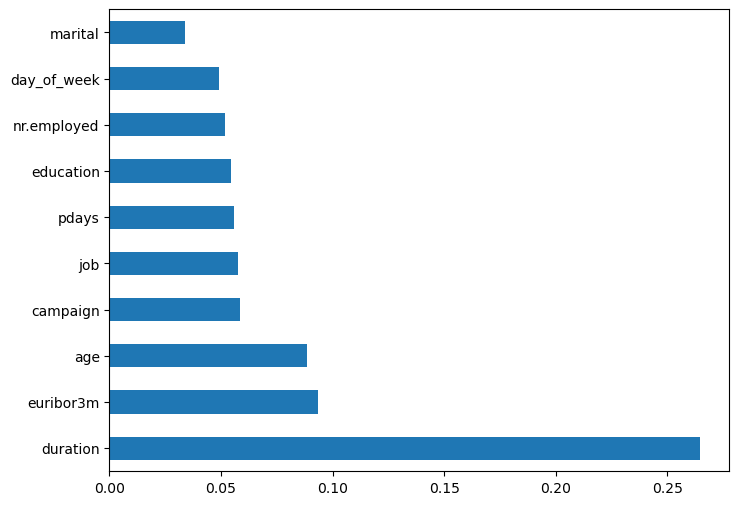

In [46]:
feat_importances = pd.Series(model.feature_importances_, index=x_enc.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

You can see that for Extra Tree Classifier impotance of features are different than in previous cases. It means that there are not exact rules for features selection. And their impotance strictly depedence on model.

### Correlation Matrix with Heatmap


Correlation states how the features are related to each other.
Correlation can be positive (increase in one value of feature increases the value of the other variable) or negative (increase in one value of feature decreases the value of the other variable)
Heatmap makes it easy to identify which features are most related to the other variable, we will plot heatmap of correlated features using the seaborn library.

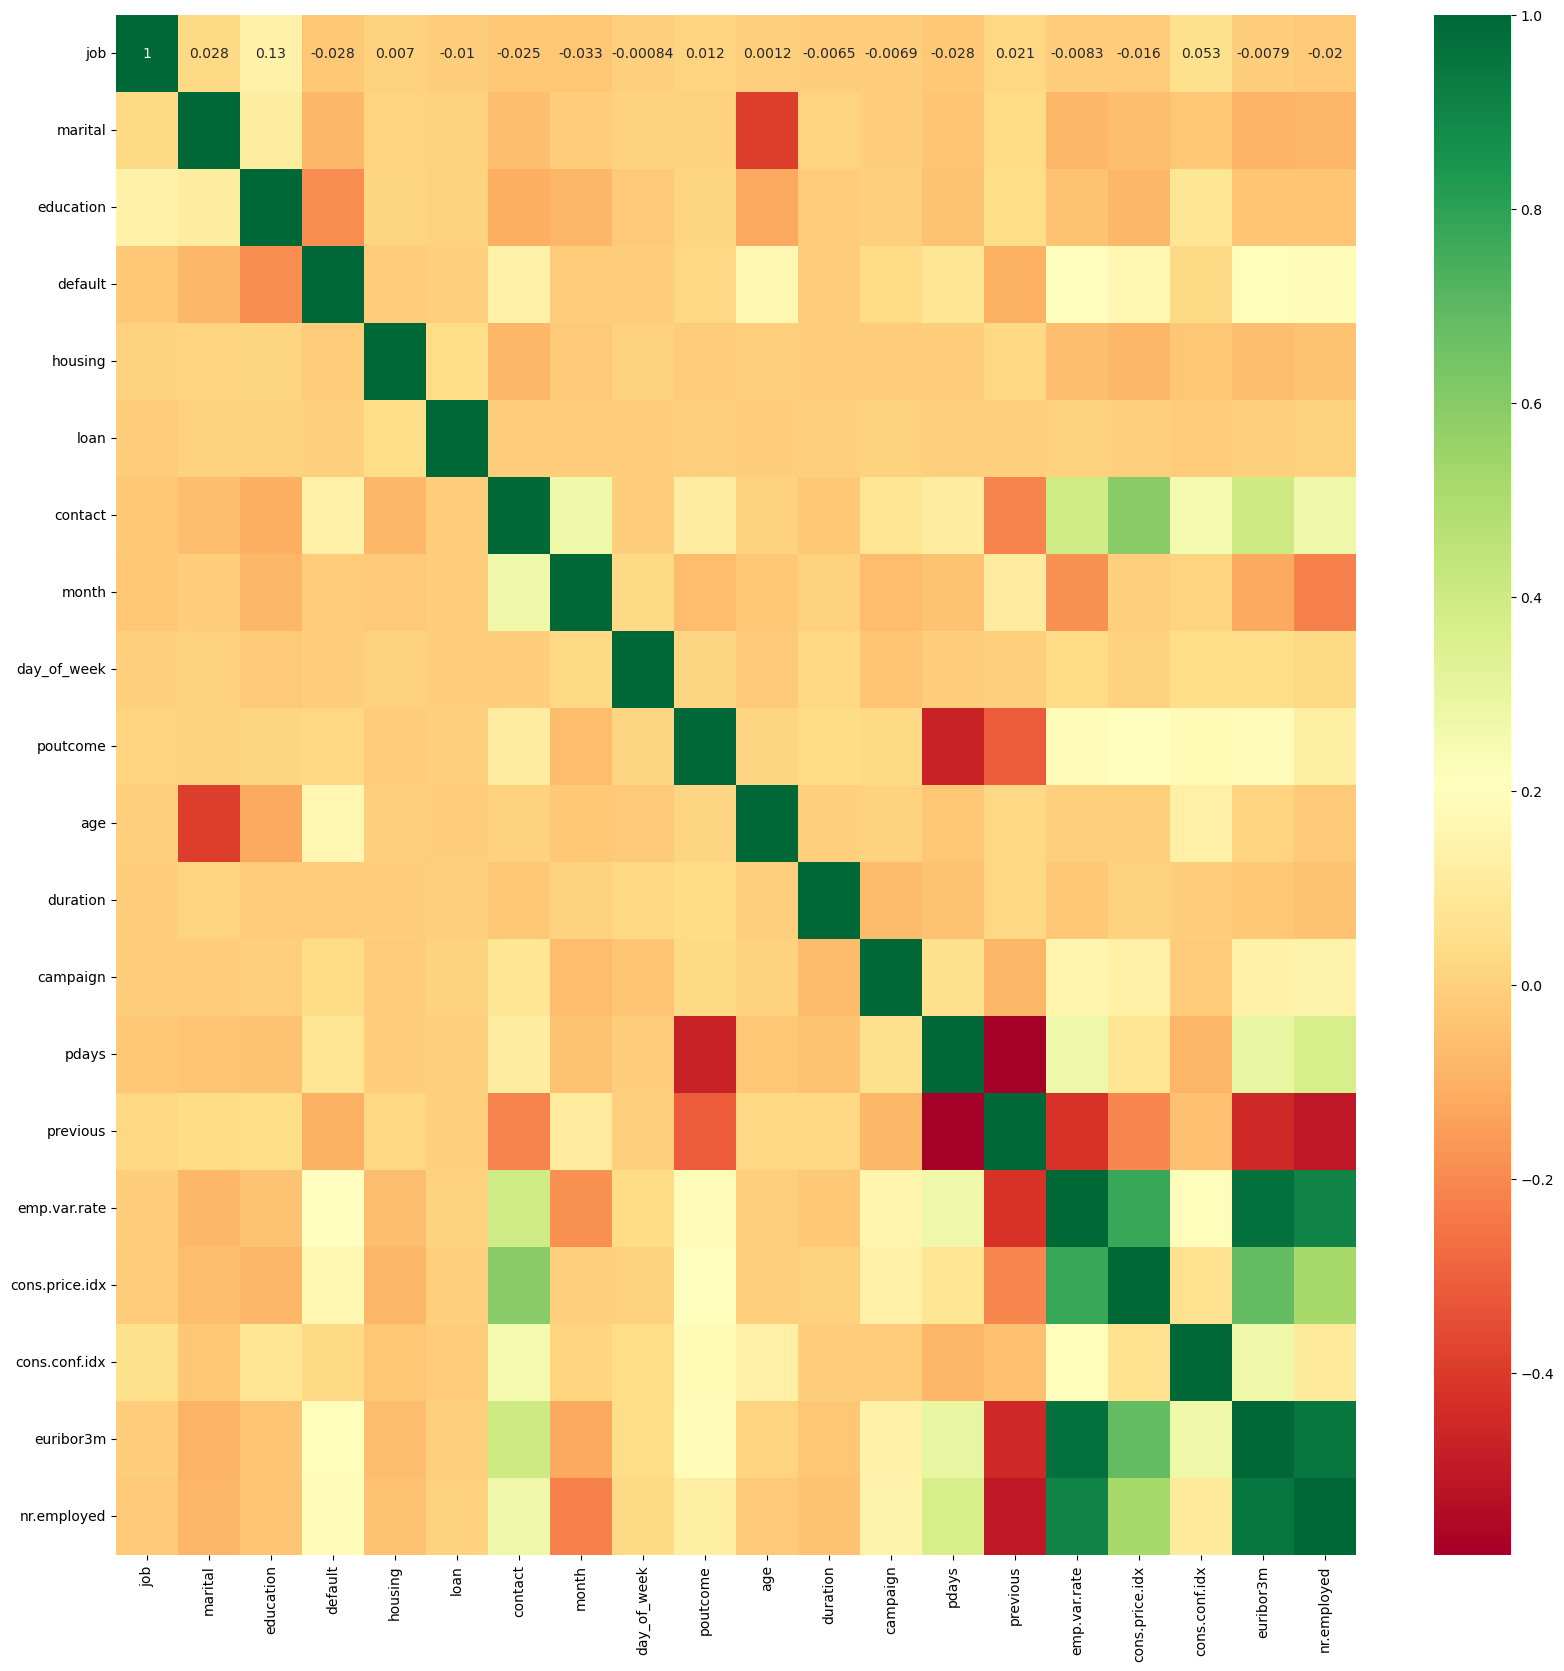

In [56]:
corrmat = x_enc.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(x_enc[top_corr_features].corr(),annot=True,cmap="RdYlGn")

As you can see fields 'euribor3m', 'emp.var.rate', 'nr.employed' strictly correlate each other. It mean that two of them must be removed from calculation because there are linear depedencies between them. If we know one of them we can easy calculate another two. Let's remove 'emp.var.rate' and 'nr.employed'

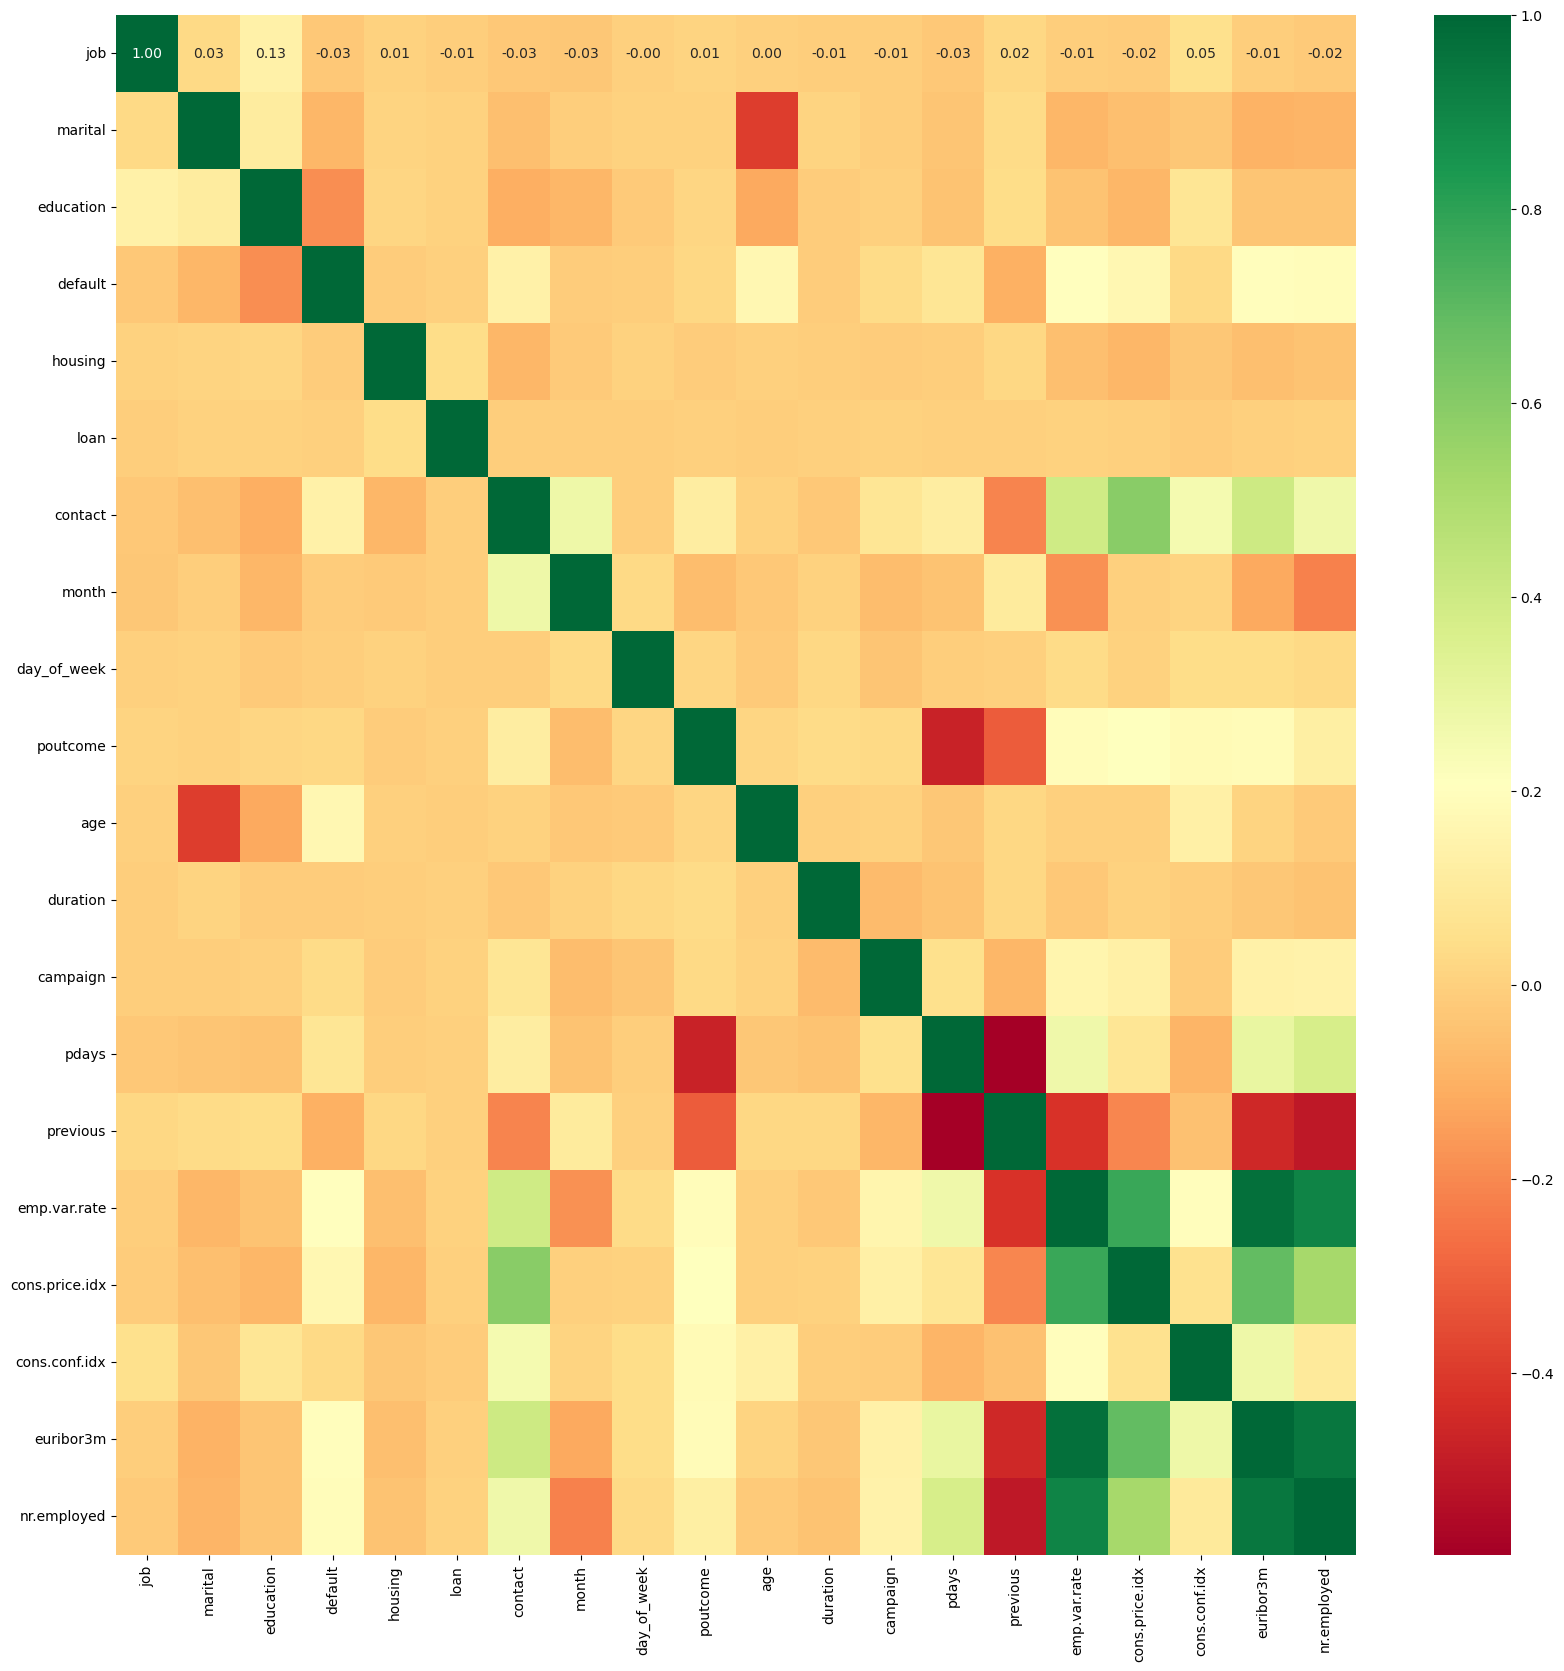

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = x_enc.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(20,20))
g = sns.heatmap(x_enc[top_corr_features].corr(), annot=True, cmap="RdYlGn", fmt='.2f') # Đặt fmt='.2f' để giữ 2 chữ số thập phân
plt.yticks(rotation=0) # Xoay các nhãn trục y để chúng không bị cắt
plt.xticks(rotation=90) # Xoay các nhãn trục x để chúng không bị cắt
plt.show()


As you can see fields 'euribor3m', 'emp.var.rate', 'nr.employed' strictly correlate each other. It mean that two of them must be removed from calculation because there are linear depedencies between them. If we know one of them we can easy calculate another two. Let's  remove 'emp.var.rate' and 'nr.employed'


In [58]:
col = x_enc.columns
col

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'age', 'duration', 'campaign',
       'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')

In [60]:
col = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'age', 'duration', 'campaign',
       'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m']

In [61]:
x_enc = x_enc[col]

## Classification models


### Train and Test DataSets creation


First of all we must separate DataSets for train and test DataSets for calculate accuracy of models. To do this we can use **[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)**. Let's separate DataSets in 0.33 proportion train/test


In [62]:
X_train, X_test, y_train, y_test = train_test_split(x_enc, y_enc, test_size=0.33, random_state=1)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (27595, 18)
X_test: (13593, 18)
y_train: (27595,)
y_test: (13593,)


You can see that Train DataSets consists 27595 rows. Test - 13593


### Extra Trees Classifier


Let's create and fit ExtraTreesClassifier on train DataSet and calculate accuracy of classification:


In [63]:
model = ExtraTreesClassifier()
model.fit(X_train, y_train)

ExtraTreesClassifier()

Evaluate the model on test data for obtain predictions


In [64]:
yhat = model.predict(X_test)
print(yhat)

[0 0 0 ... 1 0 0]


Evaluate accuracy: 


In [65]:
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 90.75


### Logistic regression 


As you can see Accuracy of this model is very good.

There are many different techniques for scoring features and selecting features based on scores; how do you know which one to use?

A robust approach is to evaluate models using different feature selection methods (and numbers of features) and select the method that results in a model with the best performance.

**[Logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)** is a good model for testing feature selection methods as it can perform better if irrelevant features are removed from the model. We will use this model in absolutelly similar way like previous one.


In [66]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
yhat = model.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 91.01


As you can see accuracy is little better


## Decision tree


### Build model


As shown, the previous methods have high accuracy. However, the biggest drawback is the inability to visualize or justify the decision.


Decision trees are a popular supervised learning method for a variety of reasons. Benefits of decision trees include that they can be used for both regression and classification, they don’t require feature scaling, and they are relatively easy to interpret as you can visualize decision trees. This is not only a powerful way to understand your model, but also to communicate how your model works. Consequently, it would help to know how to make a visualization based on your model.


A **[Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)** is a supervised algorithm used in machine learning. It is using a binary tree graph (each node has two children) to assign for each data sample a target value. The target values are presented in the tree leaves. To reach to the leaf, the sample is propagated through nodes, starting at the root node. In each node a decision is made, to which descendant node it should go. A decision is made based on the selected sample’s feature. Decision Tree learning is a process of finding the optimal rules in each internal tree node according to the selected metric.

This metod allows also to calculate features impotance.
Let's calculate them. Choice best 10 of them. Refit the model and visualize decision tree.


In [67]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
yhat = model.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 89.05


In [68]:
print("Features impotance:", model.feature_importances_)

Features impotance: [0.04081733 0.02420278 0.04114441 0.00773929 0.01724046 0.01501206
 0.00820237 0.01465277 0.03648547 0.02172837 0.09490131 0.34939346
 0.03205551 0.01565302 0.00999035 0.01662658 0.03520018 0.21895429]


Plot graph of feature importances for better visualization


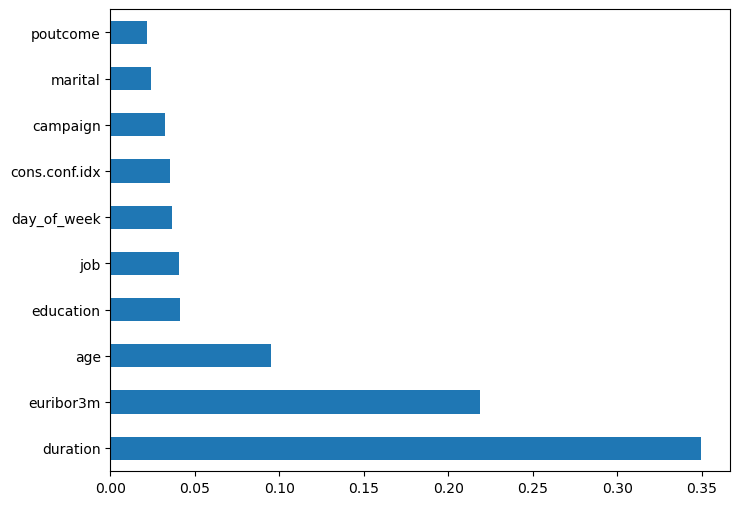

In [69]:
feat_importances = pd.Series(model.feature_importances_, index=x_enc.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Choice 10 most important:


In [70]:
feat_importances.nlargest(10)

duration        0.35
euribor3m       0.22
age             0.09
education       0.04
job             0.04
day_of_week     0.04
cons.conf.idx   0.04
campaign        0.03
marital         0.02
poutcome        0.02
dtype: float64

Create list of features


In [71]:
col = feat_importances.nlargest(10).index
col

Index(['duration', 'euribor3m', 'age', 'education', 'job', 'day_of_week',
       'cons.conf.idx', 'campaign', 'marital', 'poutcome'],
      dtype='object')

Let's refit the model on most important features


In [72]:
X_train_dt = X_train[col]
X_test_dt = X_test[col]
model.fit(X_train_dt, y_train)
yhat = model.predict(X_test_dt)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 88.92


As you can see Accuracy is little worse, because we don't use all features.


### Visualization of decision tree


Let's visualize decision tree.
There are some ways to do it. 


### _Text visualization_


In [74]:
text_representation = tree.export_text(model)
print(text_representation)

|--- feature_0 <= 0.11
|   |--- feature_1 <= 0.13
|   |   |--- feature_0 <= 0.03
|   |   |   |--- feature_9 <= 1.50
|   |   |   |   |--- feature_0 <= 0.03
|   |   |   |   |   |--- feature_0 <= 0.02
|   |   |   |   |   |   |--- feature_5 <= 3.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_5 >  3.50
|   |   |   |   |   |   |   |--- feature_6 <= 0.84
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_6 >  0.84
|   |   |   |   |   |   |   |   |--- feature_2 <= 0.18
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_2 >  0.18
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_0 >  0.02
|   |   |   |   |   |   |--- feature_1 <= 0.00
|   |   |   |   |   |   |   |--- feature_9 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_9 >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   

You can save it into file:

In [75]:
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)

### _Plot tree_

You can plot tree using by two different way:


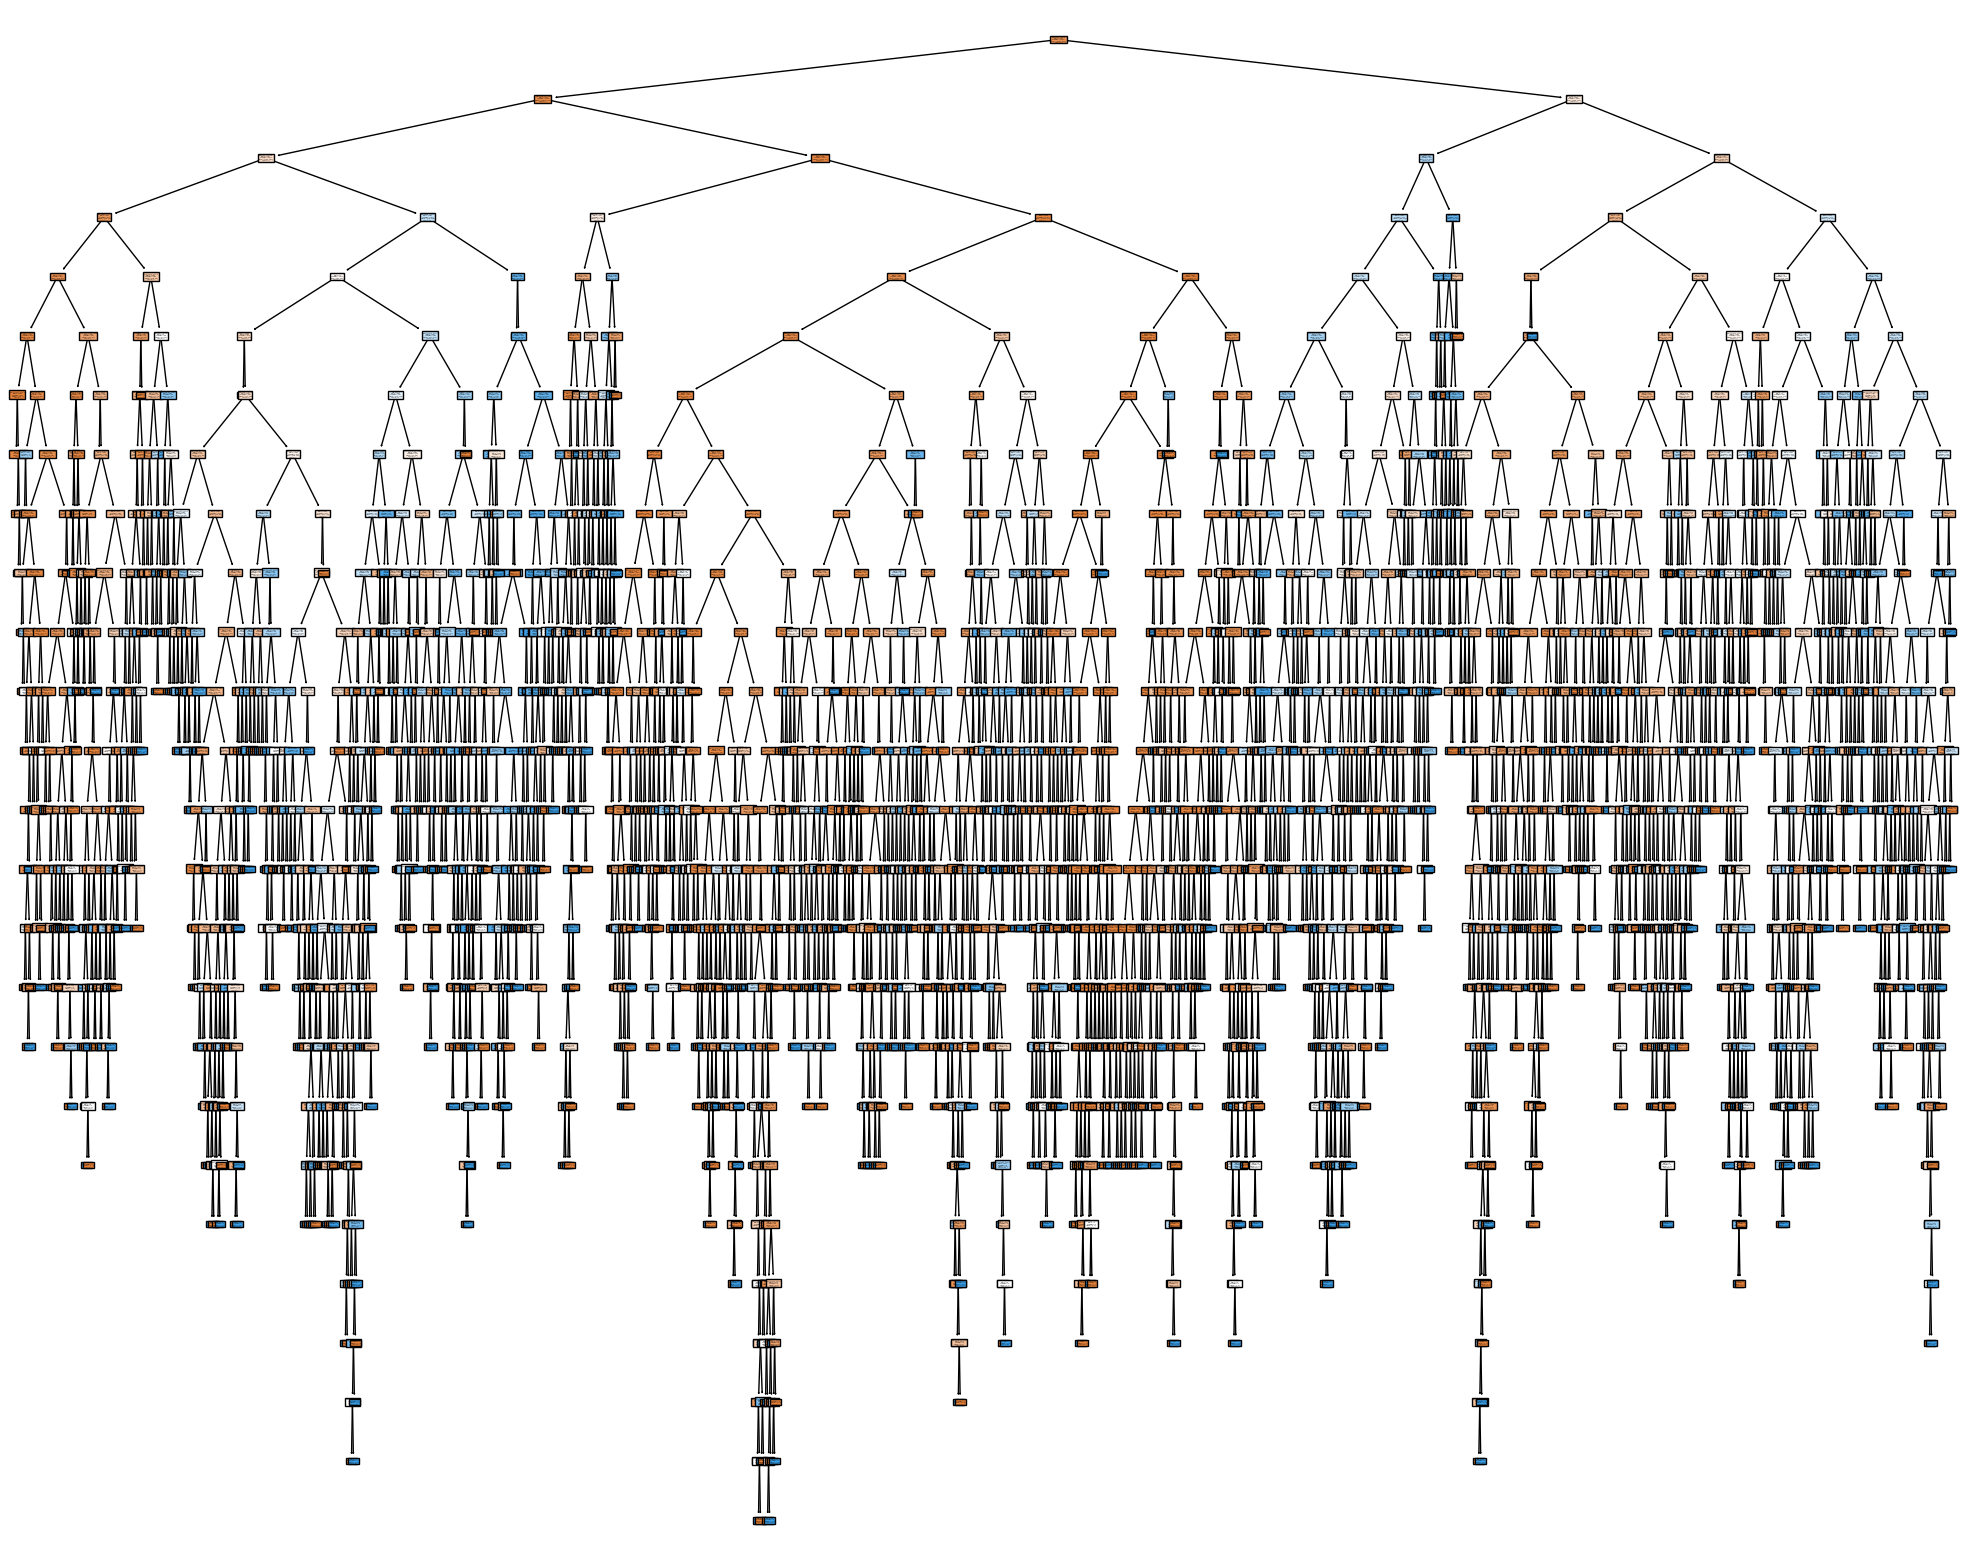

In [76]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model,
               feature_names = col, 
               class_names = y.unique(),
               filled = True)

In [77]:
fig.savefig('decision_tree_BANK.png')

Or can use **[python-graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html)** library. This is more fast function


In [79]:
# conda install python-graphviz
import graphviz
dot_data = tree.export_graphviz(model,
               feature_names = col, 
               class_names = y.unique(),
                                filled=True)

After creation you can draw graph


In [80]:
graph = graphviz.Source(dot_data, format="png") 
graph

And render it into file:


In [81]:
graph.render("decision_tree_graphivz")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.300604 to fit


'decision_tree_graphivz.png'

As a result of lab it was shown how on the basis of a statistical database predict if the client will subscribe a term deposit or no.

The accuracy of decision was abot 90%.

In [82]:
model = ExtraTreesClassifier

## Create user function that will calculate accuracy of defined classificator model?

In [83]:
def model_ac(x_train, y_train, x_test, y_test, clf):
    model = clf()
    model.fit(x_train, y_train)
    yhat = model.predict(x_test)
    accuracy = accuracy_score(y_test, yhat)
    return accuracy

In [84]:
print('Accuracy: %.2f' % (model_ac(X_train, y_train, X_test, y_test, model)*100))

Accuracy: 90.76


## Create user function that will calculate features impotance of defined classificator model

In [86]:
def model_imp(x_train, y_train, clf):
    model = clf()
    model.fit(x_train, y_train)
    feat_importances = pd.Series(model.feature_importances_, index=x_enc.columns)
    return feat_importances.sort_values(ascending=False)

In [87]:
imp = model_imp(X_train, y_train, model)
print(imp)

duration         0.26
euribor3m        0.12
age              0.08
pdays            0.06
job              0.06
campaign         0.06
education        0.05
day_of_week      0.05
cons.conf.idx    0.04
poutcome         0.04
marital          0.03
cons.price.idx   0.03
month            0.03
housing          0.03
loan             0.02
previous         0.02
contact          0.01
default          0.01
dtype: float64


## Buil plot that show accuracy of defined model depedence on numbers of input features

Input fields:  1 Accuracy: 88.60
Input fields:  2 Accuracy: 89.44
Input fields:  3 Accuracy: 90.08
Input fields:  4 Accuracy: 90.49
Input fields:  5 Accuracy: 90.36
Input fields:  6 Accuracy: 90.66
Input fields:  7 Accuracy: 90.89
Input fields:  8 Accuracy: 90.86
Input fields:  9 Accuracy: 91.02
Input fields:  10 Accuracy: 91.07
Input fields:  11 Accuracy: 91.00
Input fields:  12 Accuracy: 90.93
Input fields:  13 Accuracy: 90.78
Input fields:  14 Accuracy: 90.75
Input fields:  15 Accuracy: 90.71
Input fields:  16 Accuracy: 90.63
Input fields:  17 Accuracy: 90.93
Input fields:  18 Accuracy: 90.66


<Axes: >

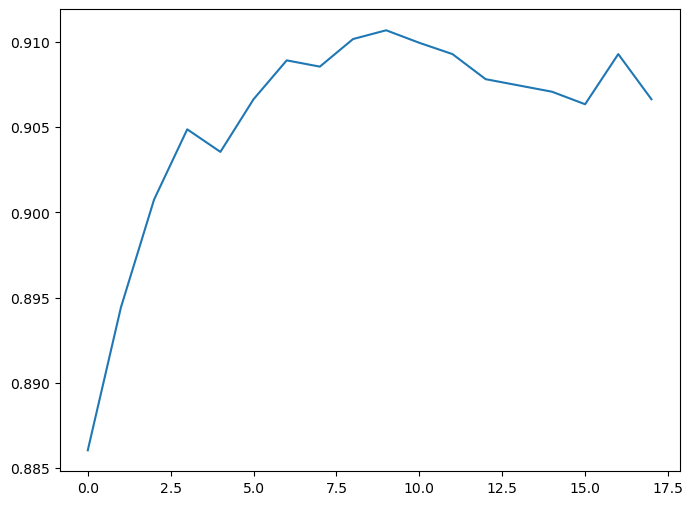

In [88]:
col = []
ac = []
for c in imp.index:
    col.append(c)
    ac.append(model_ac(X_train[col], y_train, X_test[col], y_test, model))
    print('Input fields: ', len(col), 'Accuracy: %.2f' % (ac[-1]*100))
ac = pd.Series(ac)
ac.plot()